In [9]:
import torchvision
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

In [10]:
train_path = '../data/train/'
test_path = '../data/test/'

In [11]:
# Resize because they have different sizes, flip because the apples will most likely lay down and not stand up

train_transforms = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [12]:
train_dataset = ImageFolder(root=train_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_path, transform=test_transforms)

In [13]:
def show_imgs(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ", labels)

In [14]:
train_dataset[7]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

labels:  tensor([0, 3, 2, 2, 3, 1])


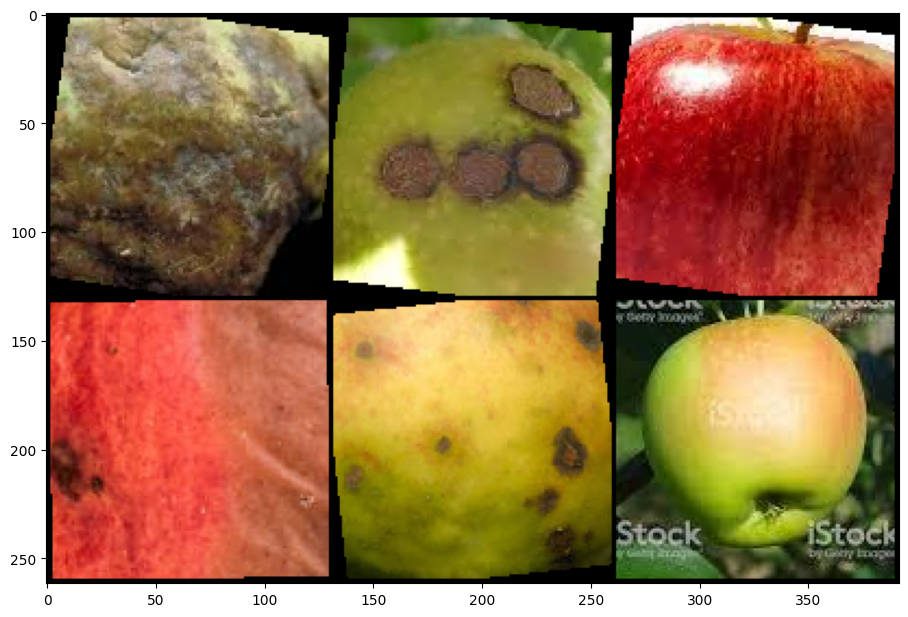

In [15]:
show_imgs(train_dataset)

batch sizes with the power of 2 starting from 16 until 1024. This is because the batch size needs to fit the memory requirements of the GPU and the architecture of the CPU.

So, the acceptable values for the batch size are 16, 32, 64, 128, 256, 512 and 1024!

In [16]:
# Minibatches because small dataset
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=False)

In [17]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [35]:
def train_model(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    
    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1) )
        
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct/total
        
        print(" - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
        

In [24]:
def evaluate_model(model, test_loader):
    model.eval()
    predicted_correct = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            output = model(images)
            
            _, predicted = torch.max(output.data, 1)
            
            predicted_correct += (predicted == labels). sum().item()
            
    

In [20]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

model_resnet18_trained = models.resnet18(pretrained=True)
model_resnet18_untrained = models.resnet18(pretrained=False)

num_ftrs = model_resnet18_untrained.fc.in_features
number_of_classes = 4 
model_resnet18_untrained.fc = nn.Linear(num_ftrs, number_of_classes)

loss_fn = nn.CrossEntropyLoss()  # experiment with different loss functions

optimizer = optim.SGD(model_resnet18_untrained.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

n_epochs = 150


c:\Users\31641\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\31641\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\31641\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

In [37]:
train_model(model_resnet18_untrained, train_loader, test_loader, loss_fn, optimizer, n_epochs=15)

Epoch number 1 
 - Training dataset. Got 198 out of 388 images correctly (51.031%). Epoch loss: 1.257
Epoch number 2 
 - Training dataset. Got 200 out of 388 images correctly (51.546%). Epoch loss: 1.121
Epoch number 3 
 - Training dataset. Got 207 out of 388 images correctly (53.351%). Epoch loss: 1.092
Epoch number 4 
 - Training dataset. Got 229 out of 388 images correctly (59.021%). Epoch loss: 1.046
Epoch number 5 
 - Training dataset. Got 222 out of 388 images correctly (57.216%). Epoch loss: 1.080
Epoch number 6 
 - Training dataset. Got 235 out of 388 images correctly (60.567%). Epoch loss: 0.985
Epoch number 7 
 - Training dataset. Got 238 out of 388 images correctly (61.340%). Epoch loss: 0.922
Epoch number 8 
 - Training dataset. Got 237 out of 388 images correctly (61.082%). Epoch loss: 0.896
Epoch number 9 
 - Training dataset. Got 235 out of 388 images correctly (60.567%). Epoch loss: 1.004
Epoch number 10 
 - Training dataset. Got 253 out of 388 images correctly (65.206%

In [ ]:
history = evaluate_model(model_resnet18_untrained, test_loader)

In [21]:
train_model(model_resnet18_trained, train_loader, test_loader, loss_fn, optimizer, n_epochs=15)

Epoch number 1 
 - Training dataset. Got 1 out of 388 images correctly (0.258%). Epoch loss: 11.359
Epoch number 2 
 - Training dataset. Got 1 out of 388 images correctly (0.258%). Epoch loss: 11.233
Epoch number 3 
 - Training dataset. Got 1 out of 388 images correctly (0.258%). Epoch loss: 11.285
Epoch number 4 
 - Training dataset. Got 1 out of 388 images correctly (0.258%). Epoch loss: 11.292
Epoch number 5 
 - Training dataset. Got 0 out of 388 images correctly (0.000%). Epoch loss: 11.347
Epoch number 6 
 - Training dataset. Got 0 out of 388 images correctly (0.000%). Epoch loss: 11.298
Epoch number 7 
 - Training dataset. Got 1 out of 388 images correctly (0.258%). Epoch loss: 11.313
Epoch number 8 
 - Training dataset. Got 0 out of 388 images correctly (0.000%). Epoch loss: 11.502
Epoch number 9 
 - Training dataset. Got 0 out of 388 images correctly (0.000%). Epoch loss: 11.563
Epoch number 10 
 - Training dataset. Got 1 out of 388 images correctly (0.258%). Epoch loss: 11.444